# Aruco marker detection, camera calibration and marker pose estimation

Aruco markers are small 2d patches that can be used as anchors for various CV tasks. They make it particularily easy to estimate the position and orientation of objects.

In [27]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import json

sys.path.append('..')

## Marker detection

The boundary of our map, as well as the robot will be tracked using Aruco markers. These are special markers that can be easily identified in image.

### Generating Aruco markers

In [28]:
import matplotlib.pyplot as plt
import json
import sys
sys.path.append("../")
from utils.aruco_generation import generate_aruco

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


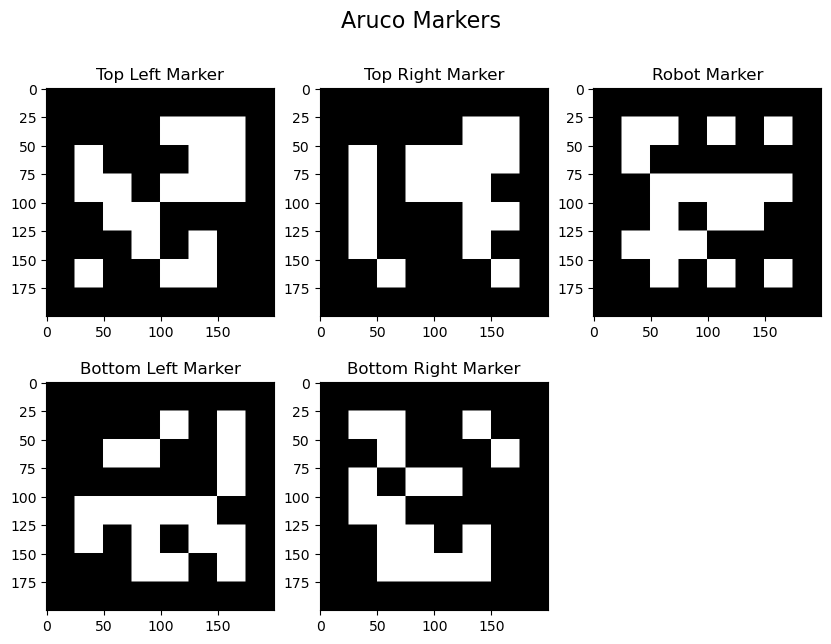

In [29]:
marker_size = 200
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

top_left_marker     = generate_aruco(0, marker_size, aruco_dict)
top_right_marker    = generate_aruco(1, marker_size, aruco_dict)
bottom_left_marker  = generate_aruco(2, marker_size, aruco_dict)
bottom_right_marker = generate_aruco(3, marker_size, aruco_dict)
robot_marker        = generate_aruco(4, marker_size, aruco_dict)

# create an image viewer where i can scroll through the markers
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0, 0].imshow(top_left_marker, cmap='gray')
axes[0, 0].set_title('Top Left Marker')
axes[0, 1].imshow(top_right_marker, cmap='gray')
axes[0, 1].set_title('Top Right Marker')
axes[1, 0].imshow(bottom_left_marker, cmap='gray')
axes[1, 0].set_title('Bottom Left Marker')
axes[1, 1].imshow(bottom_right_marker, cmap='gray')
axes[1, 1].set_title('Bottom Right Marker')
axes[0, 2].imshow(robot_marker, cmap='gray')
axes[0, 2].set_title('Robot Marker')
axes[1, 2].axis('off')

fig.suptitle('Aruco Markers', fontsize=16)

plt.show()


We will use 4 markers to create the delimiations of the map.
The fifth marker will be used to locate the robot.

### Marker detection

Now let's see the marker detection in action:

First we need to define the informations about the markers that we are using

In [30]:
from src.vision import VisionDetector

aruco_info = json.load(open('../assets/aruco/state.json', 'r'))
aruco_info

{'aruco_dict': 'DICT_6X6_250',
 'marker_size': 200,
 'top_left_id': 0,
 'top_right_id': 1,
 'bottom_left_id': 2,
 'bottom_right_id': 3,
 'robot_id': 4}

Text(0.5, 1.0, 'Original Image')

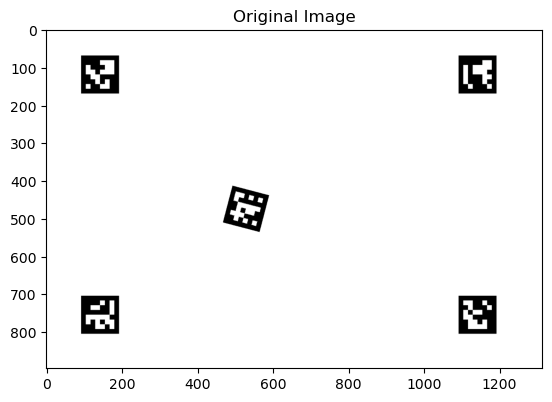

In [31]:
og_image = cv2.imread('../assets/additional/aruco_board.png')
plt.imshow(og_image)
plt.title('Original Image')

In [32]:
calibration_path = '../assets/additional/identity_calibration'
detector = VisionDetector(og_image, (1100, 700), **aruco_info)
marker_data = detector._detect_aruco(og_image)

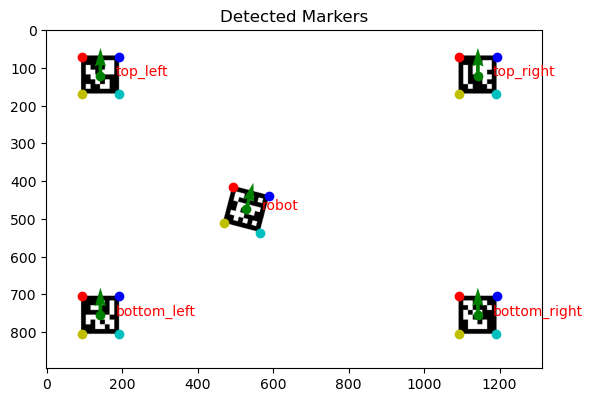

In [33]:
# plot the detected markers
plt.imshow(og_image)
for i, marker in marker_data.items():
    plt.plot(marker["center"][0], marker["center"][1], 'go')
    plt.text(marker["center"][0] + 40, marker["center"][1], i, color='red')
    plt.plot(marker["corners"][0, 0], marker["corners"][0, 1], 'ro')
    plt.plot(marker["corners"][1, 0], marker["corners"][1, 1], 'bo')
    plt.plot(marker["corners"][2, 0], marker["corners"][2, 1], 'co')
    plt.plot(marker["corners"][3, 0], marker["corners"][3, 1], 'yo')
    orientation = marker["orientation"]
    center = marker["center"]
    plt.quiver(center[0], center[1], orientation[0], -orientation[1], color='green')
    plt.title('Detected Markers')
plt.show()

### Fixing perspective in image

Now that we know how to detect the anchors, we can use some linear algebra to resolve the perspective issue.

Text(0.5, 1.0, 'Original Image')

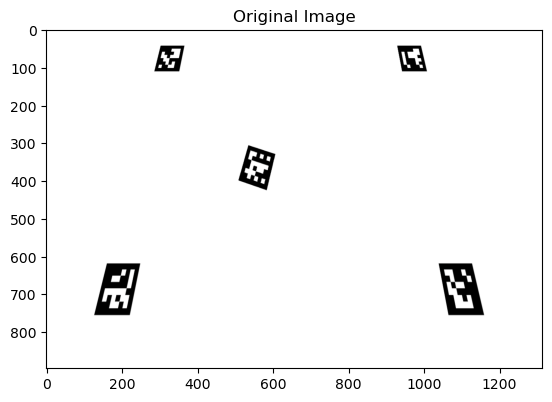

In [34]:
og_image = cv2.imread('../assets/additional/aruco_board_perspective.png')
plt.imshow(og_image)
plt.title('Original Image')

In [35]:
aruco_info = json.load(open('../assets/aruco/state.json', 'r'))
detector = VisionDetector(og_image, (1100, 700), **aruco_info)
aruco_info

{'aruco_dict': 'DICT_6X6_250',
 'marker_size': 200,
 'top_left_id': 0,
 'top_right_id': 1,
 'bottom_left_id': 2,
 'bottom_right_id': 3,
 'robot_id': 4}

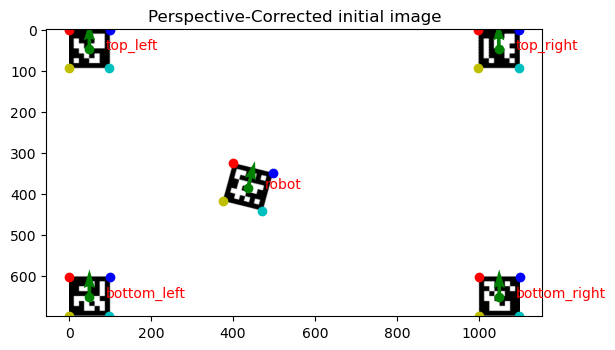

In [36]:
image = detector.get_corrected_image(og_image)
plt.imshow(image)
for i, marker in detector.transformed_aruco_state.items():
    plt.plot(marker["center"][0], marker["center"][1], 'go')
    plt.text(marker["center"][0] + 40, marker["center"][1], i, color='red')
    plt.plot(marker["corners"][0, 0], marker["corners"][0, 1], 'ro')
    plt.plot(marker["corners"][1, 0], marker["corners"][1, 1], 'bo')
    plt.plot(marker["corners"][2, 0], marker["corners"][2, 1], 'co')
    plt.plot(marker["corners"][3, 0], marker["corners"][3, 1], 'yo')
    orientation = marker["orientation"]
    plt.quiver(marker["center"][0], marker["center"][1], orientation[0], -orientation[1], color='green')
    plt.title('Perspective-Corrected initial image')
plt.show()

Now, if the robot has moved, we can still estimate where it is without having to re-compute the transformation matrix again.

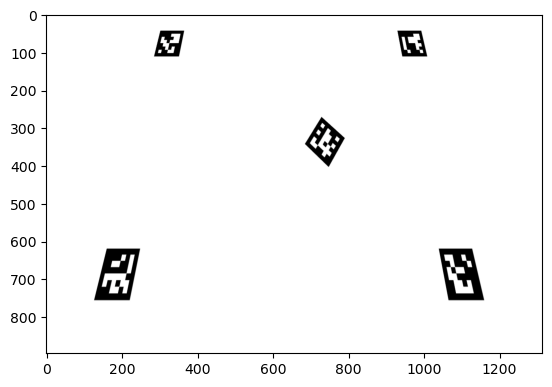

In [37]:
new_img = cv2.imread('../assets/additional/aruco_board_perspective_2.png')
plt.imshow(new_img)

We can get the state of the robot both from a distorted image and a corrected one by modifying the `is_corrected` boolean. On, the first case, the position of the robot's aruco marker is detected from the distorted image, then corrected using the perspective transform.
In the second case, the state of the robot is derived directly.

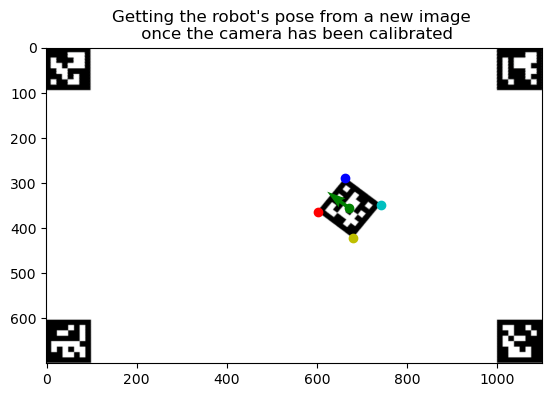

In [38]:
# robot_new_pos, robot_new_orientation, robot_corners = detector.get_robot_pose(new_img, is_corrected=False)
new_img_corrected = detector.get_corrected_image(new_img)
robot_new_pos, robot_new_orientation, robot_corners = detector.get_robot_pose(new_img_corrected, is_corrected=True)

width = np.linalg.norm(robot_corners[1] - robot_corners[0])
height = np.linalg.norm(robot_corners[3] - robot_corners[0])

# Use the average to ensure it's a square
square_size = max(width, height)  # Use max to account for irregularities

# Scale the square size by 1.3 to aproximate the robot's size
scaled_size = square_size * 1.3
half_scaled_size = scaled_size / 1.3

# Calculate the new square's corners based on the center
top_left = (int(robot_new_pos[0] - half_scaled_size), int(robot_new_pos[1] - half_scaled_size))
top_right = (int(robot_new_pos[0] + half_scaled_size), int(robot_new_pos[1] - half_scaled_size))
bottom_right = (int(robot_new_pos[0] + half_scaled_size), int(robot_new_pos[1] + half_scaled_size))
bottom_left = (int(robot_new_pos[0] - half_scaled_size), int(robot_new_pos[1] + half_scaled_size))

# Define the square corners as an array
new_square_corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)

# Draw and fill the new square
cv2.fillPoly(image, [new_square_corners], (255, 255, 255))

plt.imshow(new_img_corrected)

plt.plot(robot_corners[0, 0], robot_corners[0, 1], 'ro')
plt.plot(robot_corners[1, 0], robot_corners[1, 1], 'bo')
plt.plot(robot_corners[2, 0], robot_corners[2, 1], 'co')
plt.plot(robot_corners[3, 0], robot_corners[3, 1], 'yo')

plt.quiver(robot_new_pos[0], robot_new_pos[1], robot_new_orientation[0], -robot_new_orientation[1], color='green')
plt.plot(robot_new_pos[0], robot_new_pos[1], 'go')
plt.title('Getting the robot\'s pose from a new image \n once the camera has been calibrated')
plt.show()

Test with a real image

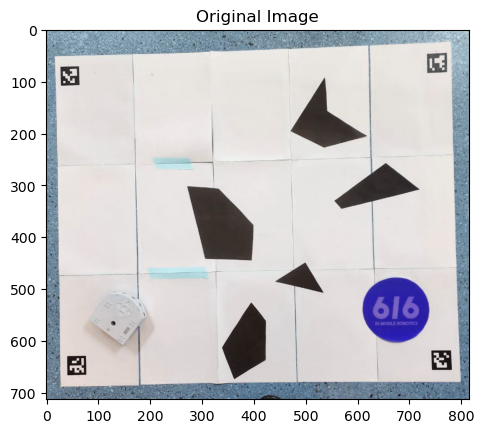

In [39]:
image = cv2.imread('../assets/additional/aruco_board_perspective_3.png')
plt.title('Original Image')
plt.imshow(image)

In [40]:
aruco_info = json.load(open('../assets/aruco/state.json', 'r'))
# calibration_path = '../assets/additional/identity_calibration'
calibration_path = None
detector = VisionDetector(image, (1100, 700), **aruco_info)
aruco_info

{'aruco_dict': 'DICT_6X6_250',
 'marker_size': 200,
 'top_left_id': 0,
 'top_right_id': 1,
 'bottom_left_id': 2,
 'bottom_right_id': 3,
 'robot_id': 4}

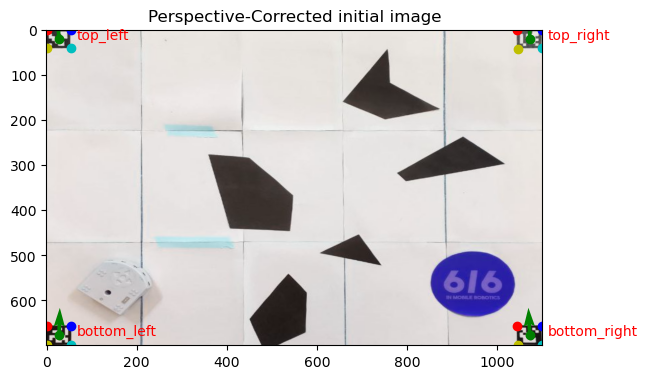

In [41]:
corrected_img = detector.get_corrected_image(image)
plt.imshow(corrected_img)
for i, marker in detector.transformed_aruco_state.items():
    plt.plot(marker["center"][0], marker["center"][1], 'go')
    plt.text(marker["center"][0] + 40, marker["center"][1], i, color='red')
    plt.plot(marker["corners"][0, 0], marker["corners"][0, 1], 'ro')
    plt.plot(marker["corners"][1, 0], marker["corners"][1, 1], 'bo')
    plt.plot(marker["corners"][2, 0], marker["corners"][2, 1], 'co')
    plt.plot(marker["corners"][3, 0], marker["corners"][3, 1], 'yo')
    orientation = marker["orientation"]
    plt.quiver(marker["center"][0], marker["center"][1], orientation[0], -orientation[1], color='green')
    plt.title('Perspective-Corrected initial image')
plt.show()

## Global object detection

### Polygon obstacle detection

Our obstacles are in the form of big black polygons. This makes the task easier!

In [42]:
import numpy as np
from typing import List

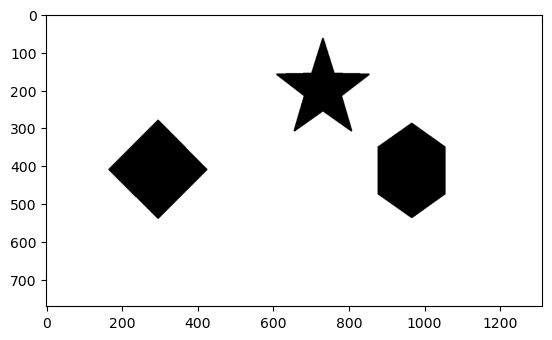

In [43]:
# import required libraries
import cv2

# read the input image
img = cv2.imread('../assets/additional/polygons.png')
plt.imshow(img)

In [44]:
from src.vision import find_polygons, extend_polygons
from src.utils import add_polygons

Once the obstacles have been detected, we can extend the position of their vertices. This defines a margin the robot should not cross.

You may notice with the star that we have removed the points that rely in convex hull of the polygons as they are useless.

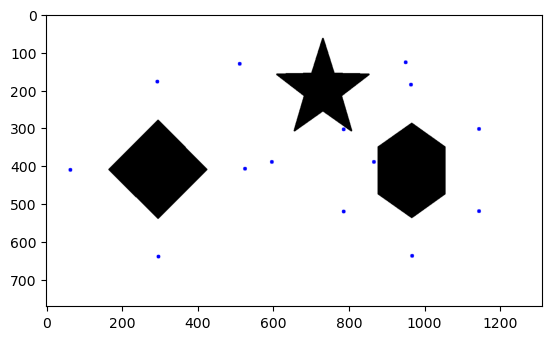

In [45]:
polygons = find_polygons(img)
extended_polygons = extend_polygons(polygons, 100)
extended_image = add_polygons(img, extended_polygons)
plt.imshow(extended_image)

### Circle reward detection

For detecting the circles, we can use Hough Transform. Here is a quick demo for detecting eye circles.

In [46]:
from src.vision import find_circles
from src.utils import add_circles

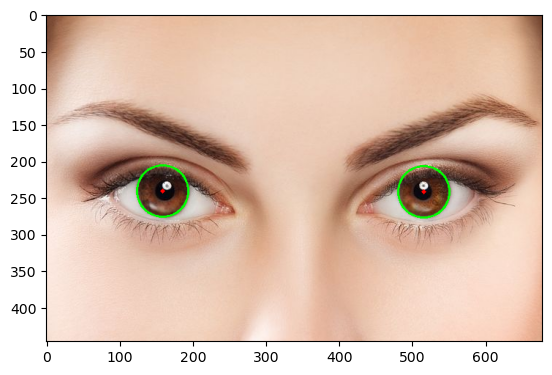

In [64]:
circle_image = cv2.imread('../assets/additional/eyes.jpeg')
# image reference: https://telegrafi.com/en/supplements-that-slow-down-the-process-of-vision-loss/
circles = find_circles(circle_image)
img_with_circles = add_circles(circle_image, circles)
plt.imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))